# Supernova distances and redshifts

####  Tasks

- First, explore fitting this data with the tecniques we have seen.
- Start from linear regression and polynomial regression
- For the case of  polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best?
- In what cases are you underfitting the data?
- In what cases are you overfitting the data?
- Now split the data into training and validation sets
- Implement a cross-validation procedure
- Pick the best!
- Does it agree with our bets?

#### If you have time (or later at home...)

- Repeat with Basis Function Regression and Kernel Regression
- Explore what happens when you change the number of datapoints and plot the resulting learning curves.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from astroML.linear_model import LinearRegression
plt.rcParams['font.size'] = 12

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl
WARN: Could not locate executable gfortran
WARN: Could not locate executable f95
WARN: Could not locate executable g95
WARN: Could not locate executable efort
WARN: Could not locate executable efc
WARN: Could not locate executable flang
WARN: don't know how to compile Fortran code on platform 'nt'


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\carlo\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Text(0.5, 1.0, 'Data')

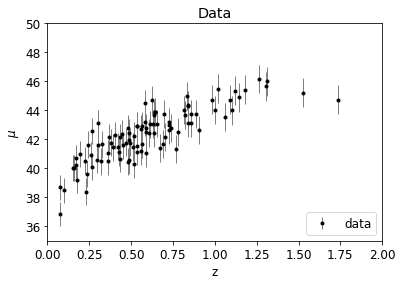

In [2]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.title('Data')

## Linear Regression

Here I start fitting the data with a linear relation, using LinearRegression. The blue line is the resulting fit using all the data, the red dashed line represents the resulting best fit excluding the points marked in red that are strong outliers if we consider a linear relation. In green the resulting fit with the Huber Loss function.

[39.48384602  4.76438865]
[39.2161331   5.30878925]
Optimization terminated successfully.
         Current function value: 0.080254
         Iterations: 71
         Function evaluations: 137


Text(0.5, 1.0, 'Linear Regression')

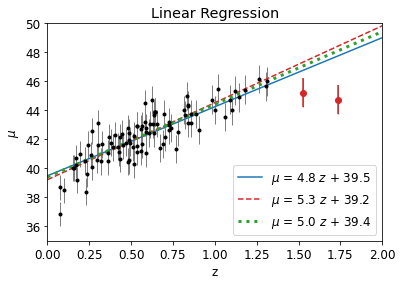

In [3]:
z_linsp = np.linspace(0,2, 100)

#Linear regression with all samples
LRmodel = LinearRegression()
LRmodel.fit(z_sample[:,None], mu_sample, dmu)
y_pred = LRmodel.predict(z_linsp[:,None])
lin_par = LRmodel.coef_
print(lin_par)

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
ax.plot(z_linsp, y_pred, label='$\mu$ = %.1f $z$ + %.1f' %(lin_par[1], lin_par[0]))

#linear regression with only points before z=1.30
z_sample_mod= z_sample[z_sample<1.4]
LRmodel.fit(z_sample_mod[:,None], mu_sample[z_sample<1.4], dmu[z_sample<1.4])
y_predmod = LRmodel.predict(z_linsp[:,None])
lin_parmod = LRmodel.coef_
print(lin_parmod)

ax.plot(z_linsp, y_predmod, label='$\mu$ = %.1f $z$ + %.1f' %(lin_parmod[1], lin_parmod[0]), ls='--', c='tab:red')
ax.errorbar(z_sample[z_sample>1.4], mu_sample[z_sample>1.4], dmu[z_sample>1.4], c='tab:red', ls='', fmt='o')
ax.set_xlabel("z")
ax.set_ylabel("$\mu$")

#Linear regression with Huber Loss function
from scipy import optimize
def huber_loss(m, b, x, y, dy, c=1):
    y_fit = m * x + b # model
    t = abs((y - y_fit) / dy) # define t
    mask = t > c # define mask for large excursion points

    return np.sum(np.logical_not(mask) * (0.5 * t ** 2) - \
                  (mask) * c * (0.5 * c - t), -1)

f_huber = lambda beta: huber_loss(beta[0], beta[1], 
                                  x=z_sample, y=mu_sample, dy=dmu, c=0.001)

# compute the maximum likelihood using the huber loss
beta0 = (1, 30)
beta_huber = optimize.fmin(f_huber, beta0)
ax.plot(z_linsp, beta_huber[0]*z_linsp+beta_huber[1], c='tab:green', ls=':', lw=3, label='$\mu$ = %.1f $z$ + %.1f' %(beta_huber[0], beta_huber[1]))

ax.legend(loc='lower right')
ax.set_xlim(0,2)
ax.set_ylim(35,50)
ax.set_title('Linear Regression')

## Polynomial Regression

Let's do polynomial regression! Here I try with different degrees.

In [4]:
from astroML.linear_model import PolynomialRegression

#selecting the degrees
degree = np.linspace(2, 7, 6)
degree = degree.astype(np.int32)
print(degree)

ypred = [] 

#fitting with polynomials
for i in range(len(degree)):
    model = PolynomialRegression(degree[i])
    model.fit(z_sample[:,None], mu_sample, dmu)
    ypred.append(model.predict(z_linsp[:,None])) #storing predictions

[2 3 4 5 6 7]


Text(0.5, 0.98, 'Polynomial Regression')

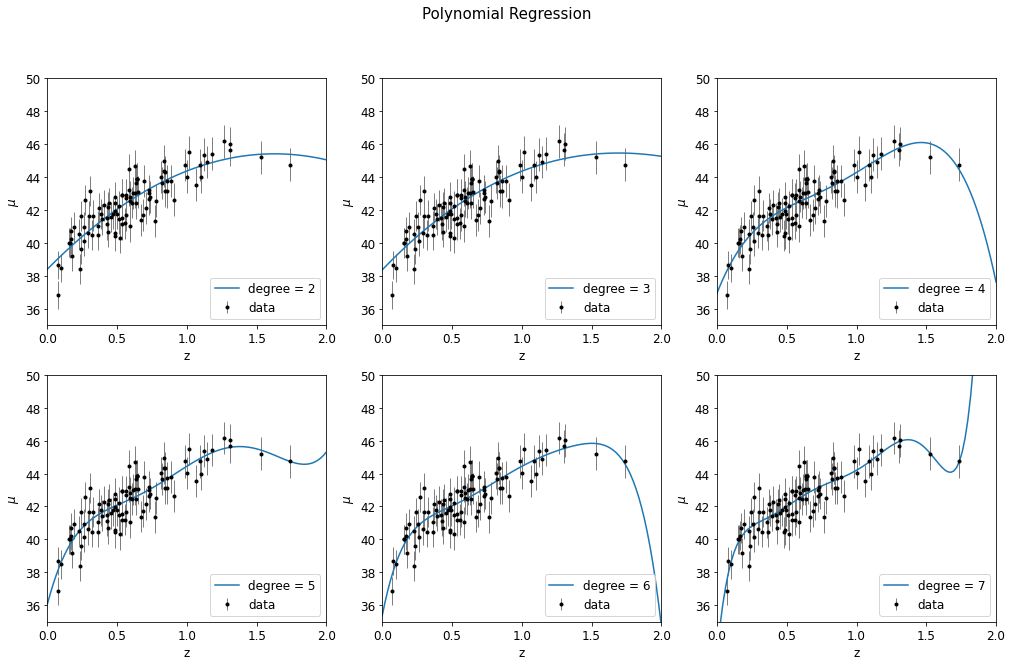

In [5]:
fig, ax = plt.subplots(2,3, figsize=(17,10))
ax= ax.reshape((6,))

for i in range(len(ax)):
    ax[i].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
    ax[i].plot(z_linsp, ypred[i], label='degree = %i' %(i+2))
    ax[i].set_xlabel("z")
    ax[i].set_ylabel("$\mu$")
    ax[i].legend(loc='lower right')
    ax[i].set_xlim(0,2)
    ax[i].set_ylim(35,50)
fig.suptitle('Polynomial Regression', fontsize=15)

Polynomial fitting seems to suggest that overfitting is definitely reach when we set the degree to 7, so it probably should be below that number. One of the best fit "by eye" seems to be the one with the degree 3 or 4 polynomial.

To choose the best degree we can implement a cross-validation procedure and select the model with the lowest cross validation error.

The minimum validation error is 0.805 and it is achieved with a polynomy of degree 4


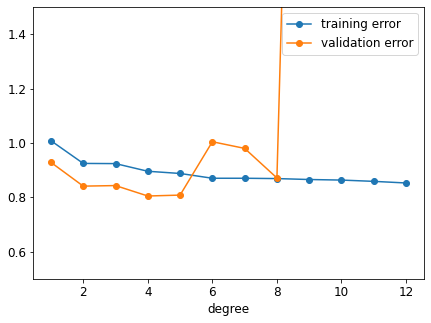

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

train_err = []
cv_err = []

#here I divide train - cv
x_train, x_cv, yanddy_train, yanddy_cv = train_test_split(z_sample[:, None], np.array([mu_sample, dmu]).T, test_size=0.25, random_state=6)
 
yanddy_train = yanddy_train.T
yanddy_cv = yanddy_cv.T

#selecting the degrees
long_degree = np.linspace(1,12,12).astype(int)


for i in range(len(long_degree)):
    model = PolynomialRegression(long_degree[i])
    model.fit(x_train, yanddy_train[0], yanddy_train[1])
    ypred_train = model.predict(x_train)
    ypred_cv = model.predict(x_cv)
    
    train_err.append(np.sqrt(np.sum((ypred_train - yanddy_train[0]) ** 2)/ len(ypred_train))) #training error
    cv_err.append(np.sqrt(np.sum((ypred_cv - yanddy_cv[0]) **2)/ len(ypred_cv) )) #cv error
         

fig, ax = plt.subplots(1,1, figsize=(7, 5))
ax.set_xlabel('degree')
ax.plot(long_degree, train_err, marker='o', label='training error')
ax.plot(long_degree, cv_err, marker='o', label='validation error')
ax.legend()
ax.set_ylim(0.5,1.5)
print('The minimum validation error is %.3f and it is achieved with a polynomy of degree %.0f' %(np.min(cv_err), long_degree[np.argmin(cv_err)]))

At the beginning the training error is higher since we are fitting data with a straight line (underfitting), therefore the bias which is telling us how far the model is from the training data is going to be high. At high degrees the validation error becomes higher, this is a sign of overfitting: our model is perfectly describing the training data, but it performs poorly on new samples. The point where the validation error and the training error are comparable and not too high is reached at a polynomial of degree = 4. 

However to arrive to this result I've chosen to set a seed for the train - cv split, changing that seed could lead to slightly different results. One way to overcome this problem could be implementing a code with a cross validation technique such that the process is repeated multiple times and each time the test set is different.

## Basis Function regression

With Basis Function regression we can fit the data with a sum of functions. In this case we try to fit a sum of Gaussians, but of course you have different parameters that you could tune: the number of Gaussians, their mean and their standard deviations. Here I try to pick the best number of Gaussians to describe our data, imposing the means as equally distributed inside the data range, and the standard deviations as half the distance between two consecutive means.

Text(0.5, 1.0, 'Basis Function Regression: Gaussians')

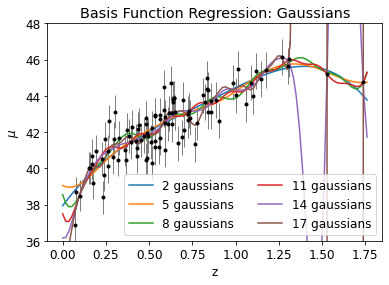

In [7]:
from astroML.linear_model import BasisFunctionRegression
z_lin = np.linspace(0, 1.76, 100)
y_pred_bf = []

for n in np.arange(2,20):
    mean_g = np.linspace(0,1.75,n)[:,None] #means equally distant
    sigma_g = (mean_g[1]-mean_g[0])/2    #st. dev
    modelbf = BasisFunctionRegression('gaussian', mu=mean_g, sigma=sigma_g)
    modelbf.fit(z_sample[:,None], mu_sample, dmu)
    y_pred_bf.append(modelbf.predict(z_lin[:,None]))
    
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

for i in np.arange(2,20)[::3]:
    ax.plot(z_lin, y_pred_bf[i-2], label='%i gaussians' %(i))
ax.legend(ncol=2)
ax.set_ylim(36,48)
ax.set_xlabel('z')
ax.set_ylabel('$\mu$')
ax.set_title('Basis Function Regression: Gaussians')

We can clearly see that with 14 components or more we are definitely overfitting data! To choose the best number I implement a cross-validation procedure below.

The minimum of the validation error is 1.006 achieved by 8 gaussians


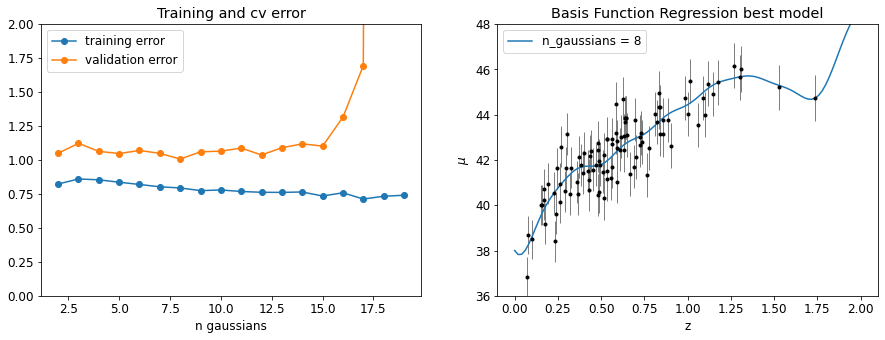

In [8]:
train_err_bfr = []
cv_err_bfr = []

#here I divide train - cv
x_train, x_cv, yanddy_train, yanddy_cv = train_test_split(z_sample[:, None], np.array([mu_sample, dmu]).T, test_size=0.25, random_state=515)
 
yanddy_train = yanddy_train.T
yanddy_cv = yanddy_cv.T


for n in np.arange(2,20):
    mean_g = np.linspace(0,1.75,n)[:,None]
    sigma_g = (mean_g[1]-mean_g[0])/2
    modelbf = BasisFunctionRegression('gaussian', mu=mean_g, sigma=sigma_g)
    modelbf.fit(x_train, yanddy_train[0], yanddy_train[1])
    y_pred_train = modelbf.predict(x_train)
    y_pred_cv = modelbf.predict(x_cv)
    
    train_err_bfr.append(np.sqrt(np.sum((y_pred_train - yanddy_train[0]) ** 2)/ len(y_pred_train))) #training error
    cv_err_bfr.append(np.sqrt(np.sum((y_pred_cv - yanddy_cv[0]) **2)/ len(y_pred_cv) )) #cv error
         
#plotting train and cv errors
fig, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].set_xlabel('n gaussians')
ax[0].plot(np.arange(2,20), train_err_bfr, label='training error', marker='o')
ax[0].plot(np.arange(2,20), cv_err_bfr, label='validation error', marker='o' )
ax[0].legend()
ax[0].set_ylim(0,2)
ax[0].set_title('Training and cv error')

#plotting the best model (8 gaussians)
mean_g = np.linspace(0,1.75,8)[:,None]
sigma_g = (mean_g[1]-mean_g[0])/2
modelbf = BasisFunctionRegression('gaussian', mu=mean_g, sigma=sigma_g)
modelbf.fit(x_train, yanddy_train[0], yanddy_train[1])
y_pred_linsp = modelbf.predict(z_linsp[:,None])

ax[1].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
ax[1].plot(z_linsp, y_pred_linsp, label='n_gaussians = 8')
ax[1].legend()
ax[1].set_ylim(36,48)
ax[1].set_title('Basis Function Regression best model')
ax[1].set_xlabel('z')
ax[1].set_ylabel('$\mu$')

print('The minimum of the validation error is %.3f achieved by %.0f gaussians' %(np.min(cv_err_bfr), np.argmin(cv_err_bfr)+2))

Even here we can observe how introducing more gaussians components leads to a decrease in the training error as the bias is getting lower. The validation error reaches a minimum for 8 Gaussians, which is chosen to be the best model, and then it increases adding more components because of the increase in the variance. With more than 15 components we are definitely overfitting. However results may change with the choice of the width or the mean of the Gaussians!

## Kernel regression

Kernel regression could be seen as an extreme case of Basis Function Regression, infact in this case we are fitting the data with a sum of Gaussians such that each of them is centered in a data point! This is also called Nadaraya-Watson fit. The hyperparameter to fit is the bandwidth, that is determining the $\sigma$ of the Gaussians functions.

C:\Users\carlo\anaconda3\lib\site-packages\astroML\linear_model\kernel_regression.py:52: RuntimeWarning: invalid value encountered in true_divide
  return (K * self.y).sum(1) / K.sum(1)


Text(0.5, 1.0, 'Karnel Regression: Gaussians')

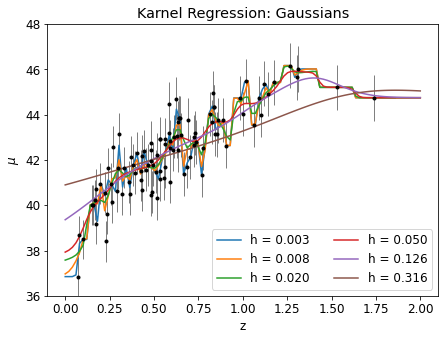

In [9]:
from astroML.linear_model import NadarayaWatson

h_range = np.logspace(-2.5, -0.5, 6)
y_pred_nw = []

for i in range(len(h_range)):
    model_nw = NadarayaWatson(kernel='gaussian', h=h_range[i])
    model_nw.fit(z_sample[:,None], mu_sample, dmu)
    y_pred_nw.append(model_nw.predict(z_linsp[:,None]))

fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

for i in range(len(h_range)):
    ax.plot(z_linsp, y_pred_nw[i], label='h = %.3f' %(h_range[i]))
ax.legend(ncol=2)
ax.set_ylim(36,48)

ax.set_xlabel('z')
ax.set_ylabel('$\mu$')
ax.set_title('Karnel Regression: Gaussians')

We are definitely underfitting with h>0.3 but also overfitting with h<0.02. Let's see what the training and cv errors are.

The minimum validation error is 1.065 and it is achieved for a bandwidth of 0.04053


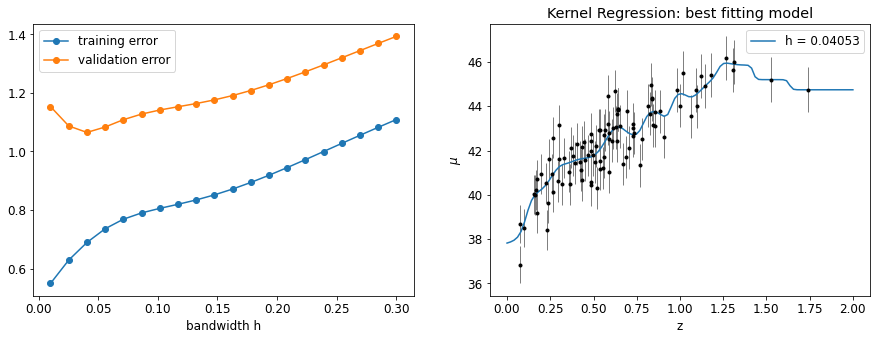

In [10]:
train_err_kr = []
cv_err_kr = []

#here I divide train - cv
x_train, x_cv, yanddy_train, yanddy_cv = train_test_split(z_sample[:, None], np.array([mu_sample, dmu]).T, test_size=0.3, random_state=15)
 
yanddy_train = yanddy_train.T
yanddy_cv = yanddy_cv.T

h_range = np.linspace(0.01, 0.3, 20)
for i in range(len(h_range)):
    model_nw = NadarayaWatson(kernel='gaussian', h=h_range[i])
    model_nw.fit(x_train, yanddy_train[0], yanddy_train[1])
    y_pred_train = model_nw.predict(x_train)
    y_pred_cv = model_nw.predict(x_cv)
    
    train_err_kr.append(np.sqrt(np.sum((y_pred_train - yanddy_train[0]) ** 2)/ len(y_pred_train))) #training error
    cv_err_kr.append(np.sqrt(np.sum((y_pred_cv - yanddy_cv[0]) **2)/ len(y_pred_cv) )) #cv error
         
#plotting errors
fig, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].set_xlabel('bandwidth h')
ax[0].plot(h_range, train_err_kr, marker='o', label='training error')
ax[0].plot(h_range, cv_err_kr, marker='o', label='validation error')
ax[0].legend()

#plotting the best model
model_nw = NadarayaWatson(kernel='gaussian', h=h_range[np.argmin(cv_err_kr)])
model_nw.fit(z_sample[:,None], mu_sample, dmu)
y_pred_linsp = model_nw.predict(z_linsp[:,None])

ax[1].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
ax[1].plot(z_linsp, y_pred_linsp, label='h = %.5f' %h_range[np.argmin(cv_err_kr)])
ax[1].set_xlabel('z')
ax[1].set_ylabel('$\mu$')
ax[1].set_title('Kernel Regression: best fitting model')
ax[1].legend()

print('The minimum validation error is %.3f and it is achieved for a bandwidth of %.5f' %(np.min(cv_err_kr), h_range[np.argmin(cv_err_kr)]))

Here we should read the plot from right to left, since high bandwidths correspond to high bias, while low bandwidths to high variance. The optimal value corresponding to the minimum validation error is about 0.04.